# Imports

In [4]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import skimage.io
import seaborn as sn

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [7]:
import tensorflow.python.keras.backend as K

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Treinamento e teste 

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

# valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [10]:
train_dataset  = train_datagen.flow_from_directory(directory = 'train_apagar',
                                                   target_size = (48,48),
                                                   color_mode = "rgb",
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle=True)

Found 119 images belonging to 7 classes.


In [11]:
result = next(train_dataset)

In [12]:
result[0].shape

(64, 48, 48, 3)

In [13]:
teste_y = train_dataset.classes

In [14]:
valid_dataset = train_datagen.flow_from_directory(directory = 'train_apagar',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 28 images belonging to 7 classes.


In [15]:
test_dataset = test_datagen.flow_from_directory(directory = 'test_apagar',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 98 images belonging to 7 classes.


# Construção Modelo

In [16]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [17]:
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False

In [18]:
custom_model = Sequential()

custom_model.add(Dropout(0.5))
custom_model.add(Flatten())
custom_model.add(BatchNormalization())
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(32,kernel_initializer='he_uniform'))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(Dense(7,activation='softmax'))

In [19]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(custom_model)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential (Sequential)      (None, 7)                 21191     
Total params: 14,735,879
Trainable params: 19,975
Non-trainable params: 14,715,904
_________________________________________________________________


In [21]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png') 

In [22]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [24]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model_tentando.h5')

es = EarlyStopping(verbose=1, patience=20)

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

# Fit do modelo 

In [26]:
from keras.callbacks import CSVLogger

In [27]:
epochs = 5 #PARA TESTE
#epochs = 60
batch_size = 64
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = epochs,verbose = 1,callbacks=[lrd,mcp,es])


Epoch 1/5
2/2 [==============================] - 8s 4s/step - loss: 2.3322 - accuracy: 0.8415 - precision: 0.0667 - recall: 0.0084 - auc: 0.4601 - f1_score: 0.0139 - val_loss: 1.9991 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5547 - val_f1_score: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 4s 2s/step - loss: 2.2415 - accuracy: 0.8439 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5076 - f1_score: 0.0000e+00 - val_loss: 2.0586 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4964 - val_f1_score: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 4s 3s/step - loss: 2.2377 - accuracy: 0.8463 - precision: 0.2353 - recall: 0.0336 - auc: 0.4922 - f1_score: 0.0591 - val_loss: 2.0338 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5085 - val_f1_score: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 4s 2s/step - loss: 2.1679 -

## Salvando o history em json

In [28]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history_tentando.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    

## Salvando o modelo

In [29]:
custom_model.save("tentando/modelo_tentando")

INFO:tensorflow:Assets written to: tentando/modelo_tentando/assets


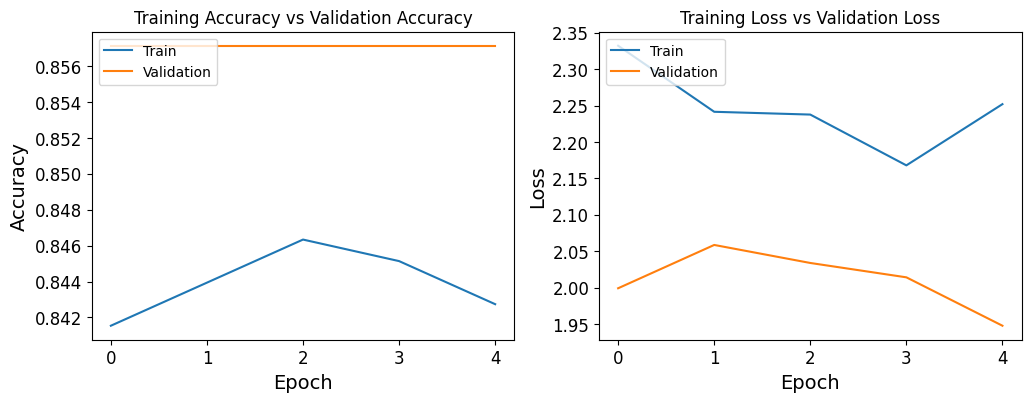

In [30]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
train_l = history.history['val_accuracy']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Evaluate 

In [ ]:
results = model.evaluate(test_dataset, batch_size=64)